# **Mounting Drive**

DIV2K AND FLIKR2K 14 GB

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Model**

In [2]:
import torch
from torch import nn


from torch.nn.utils import spectral_norm

class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_activation=True,
        use_batchnorm=True,
        use_spectral_norm=False,  # New parameter for spectral normalization
        **kwargs,
    ):
        super().__init__()
        self.use_activation = use_activation
        self.use_spectral_norm = use_spectral_norm

        # Apply spectral normalization if required
        conv_layer = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_batchnorm)
        self.cnn = spectral_norm(conv_layer) if use_spectral_norm else conv_layer

        self.bn = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        return self.act(self.bn(self.cnn(x))) if self.use_activation else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out*0.2 + x


1. ConvBlock

    The ConvBlock is the foundational layer used in both the generator and discriminator. It combines convolution, batch normalization, and activation functions to extract features and ensure smooth gradient flow.
    
    Significance: This block acts as the core building unit, enabling the network to process image data effectively and learn hierarchical features.

2. UpsampleBlock

    Purpose: The UpsampleBlock is used exclusively in the generator to increase the resolution of the feature maps. It ensures that the low-resolution input is gradually scaled up to high resolution.
    
    Significance: This block replaces traditional deconvolution operations, avoiding checkerboard artifacts and maintaining the visual quality of the output.

3. ResidualBlock

    Purpose: The ResidualBlock is central to the generator's architecture. It refines the image features and helps the network capture high-level details without introducing vanishing gradient problems.
    
    Significance: By stacking multiple ResidualBlocks, the generator can model fine textures and complex patterns, critical for producing realistic high-resolution images.

In [3]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=24):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_batchnorm=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2), UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return torch.tanh(self.final(x))





class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_activation=True,
                    use_batchnorm=False if idx == 0 else True,
                    use_spectral_norm=True,  # Enable spectral normalization here
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)


4. Generator

    Purpose: The generator synthesizes high-resolution images from low-resolution inputs by combining the above building blocks.
    Architecture:
      
    Significance: The generator is the heart of the SRGAN, designed to generate perceptually convincing high-resolution outputs.

5. Discriminator

    Purpose: The discriminator acts as an adversary to the generator, learning to distinguish real high-resolution images from fake ones. This pushes the generator to improve.
    
    Significance: The discriminator plays a critical role in the adversarial learning process, encouraging the generator to produce images that are visually indistinguishable from real ones.

In [4]:
def test():
    low_resolution = 24  # 96x96 -> 24x24
    with torch.cuda.amp.autocast():
        x = torch.randn((5, 3, low_resolution, low_resolution))
        gen = Generator()
        gen_out = gen(x)
        disc = Discriminator()
        disc_out = disc(gen_out)

        print(gen_out.shape)
        print(disc_out.shape)


if __name__ == "__main__":
    test()

<ipython-input-4-ee92c9f65ca7>:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#**Loss function**

In [6]:
import torch.nn as nn
from torchvision.models import vgg19

In [7]:

class VGGLoss(nn.Module):
    def __init__(self, feature_layer=21):  # Specify the layer to use (default: 21)
        super().__init__()
        vgg = vgg19(pretrained=True).features
        # Extract layers up to the specified feature_layer
        self.vgg = nn.Sequential(*list(vgg.children())[:feature_layer]).eval()
        self.loss = nn.MSELoss()

        # Freeze the parameters of the VGG model
        for param in self.vgg.parameters():
            param.requires_grad = False

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.vgg.to(self.device)

    def forward(self, input, target):
        # Ensure input and target are normalized with mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        input = (input - 0.5) / 0.5
        target = (target - 0.5) / 0.5

        # Extract features from input and target
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        # Compute MSE loss between the extracted features
        return self.loss(vgg_input_features, vgg_target_features)



1. Loss Functions
Content Loss

    Purpose: To ensure the generated image not only resembles the high-resolution target but also retains perceptual quality that aligns with human visual preferences.
    
    Significance: Content loss encourages the generator to focus on visual features that are perceptually important, like edges, textures, and structures.

#**Config**

In [8]:
import torch
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

LOAD_MODEL = False
SAVE_MODEL = True
# CHECKPOINT_GEN = "gen.pth.tar"
# CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "/content/drive/MyDrive/Models/gen.pth.tar"
CHECKPOINT_DISC = "/content/drive/MyDrive/Models/disc.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
BATCH_SIZE = 16
NUM_WORKERS = 4
HIGH_RES = 96
LOW_RES = HIGH_RES // 4
IMG_CHANNELS = 3

highres_transform = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ]
)


lowres_transform = A.Compose(
    [
        A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ]
)

both_transforms = A.Compose(
    [
        A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# **Dataset**

In [9]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader


class MyImageFolder(Dataset):
  def __init__(self, root_dir):
        super(MyImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index] * len(files)))

  def __len__(self):
        return len(self.data)

  def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])

        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))
        image = both_transforms(image=image)["image"]
        high_res = highres_transform(image=image)["image"]
        low_res = lowres_transform(image=image)["image"]
        return low_res, high_res


def test():
    dataset = MyImageFolder(root_dir="/content/drive/MyDrive/Data/hr/train/")
    loader = DataLoader(dataset, batch_size=1, num_workers=8)

    for low_res, high_res in loader:
        print(low_res.shape)
        print(high_res.shape)


if __name__ == "__main__":
    test()

Streaming output truncated to the last 5000 lines.
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torch.Size([1, 3, 96, 96])
torch.Size([1, 3, 24, 24])
torc

# **Utils**

In [10]:
import torch
import os
import numpy as np
from PIL import Image
from torchvision.utils import save_image


def gradient_penalty(critic, real, fake, device):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake.detach() * (1 - alpha)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def plot_examples(low_res_folder, gen):
    files = os.listdir(low_res_folder)

    gen.eval()
    for file in files:
        image = Image.open("/content/drive/MyDrive/Data/hr/test/LR/" + file)

        if image.mode != 'RGB':
            image = image.convert('RGB')
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, f"/content/drive/MyDrive/Data/hr/saved/{file}")
    gen.train()

#**Train**

In [12]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.backends.cudnn.benchmark = True


def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, epoch):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        #l2_loss = mse(fake, high_res)
        # adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        adversarial_loss = 1e-1 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)

        pixel_loss = nn.L1Loss()(fake, high_res)
        # gen_loss = adversarial_loss + loss_for_vgg + 0.1 * pixel_loss
        adversarial_weight = epoch/NUM_EPOCHS * 0.1  # Gradually increase adversarial weight
        gen_loss =  0.1*pixel_loss + loss_for_vgg + adversarial_weight * adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        if idx % 200 == 0:
            plot_examples("/content/drive/MyDrive/Data/hr/test/LR/", gen)


def main():
    dataset = MyImageFolder(root_dir="/content/drive/MyDrive/Data/hr/train/")
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    gen = Generator(in_channels=3).to(DEVICE)
    disc = Discriminator(in_channels=3).to(DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()
    # vgg_loss = VGGLoss()
    vgg_loss = VGGLoss(feature_layer=21)  # Specify the layer you want to use

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN,
            gen,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
           CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )
    scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=20, gamma=0.5)
    scheduler_disc = torch.optim.lr_scheduler.StepLR(opt_disc, step_size=20, gamma=0.5)


    for epoch in range(NUM_EPOCHS):
        train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, epoch)

        scheduler_gen.step()
        scheduler_disc.step()



        if SAVE_MODEL:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)


if __name__ == "__main__":
    main()

100%|██████████| 216/216 [02:34<00:00,  1.40it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [01:59<00:00,  1.80it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:00<00:00,  1.79it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:01<00:00,  1.78it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:01<00:00,  1.78it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:00<00:00,  1.80it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:00<00:00,  1.79it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:01<00:00,  1.78it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:01<00:00,  1.78it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:02<00:00,  1.76it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:06<00:00,  1.71it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:02<00:00,  1.76it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.76it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:06<00:00,  1.71it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:06<00:00,  1.71it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:02<00:00,  1.76it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:03<00:00,  1.75it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.73it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:05<00:00,  1.72it/s]


=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 216/216 [02:04<00:00,  1.74it/s]


=> Saving checkpoint
=> Saving checkpoint


#**Evaluation**

In [13]:
import torch
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import os
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2

# Path configurations
CHECKPOINT_GEN = "/content/drive/MyDrive/Models/gen.pth.tar"
INPUT_FOLDER = "/content/drive/MyDrive/Data/hr/test/LR"  # Path to low-resolution images
OUTPUT_FOLDER = "/content/drive/MyDrive/Data/hr/predict"  # Path to save super-resolved images

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define transforms for the input images
test_transform = Compose([
    Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
    ToTensorV2(),
])

# Load the generator model
def load_generator(checkpoint_path, device):
    model = Generator(in_channels=3).to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()  # Set the model to evaluation mode
    print("=> Generator model loaded successfully!")
    return model

# Function to process low-resolution images and generate super-resolved images
def process_images(generator, input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all images in the input folder
    for file_name in os.listdir(input_folder):
        file_path = os.path.join(input_folder, file_name)

        # Open and preprocess the image
        image = Image.open(file_path)
        if image.mode != "RGB":
            image = image.convert("RGB")  # Ensure image is in RGB mode

        # Apply transformations
        low_res = test_transform(image=np.array(image))["image"]
        low_res = low_res.unsqueeze(0).to(DEVICE)  # Add batch dimension

        # Generate the super-resolution image
        with torch.no_grad():
            super_res = generator(low_res)
            super_res = super_res * 0.5 + 0.5  # De-normalize to [0, 1]

        # Save the super-resolution image
        output_path = os.path.join(output_folder, file_name)
        save_image(super_res, output_path)
        print(f"Saved super-resolution image: {output_path}")

# Main testing pipeline
def test_pipeline():
    # Load the generator model
    generator = load_generator(CHECKPOINT_GEN, DEVICE)

    # Process and generate high-resolution images
    process_images(generator, INPUT_FOLDER, OUTPUT_FOLDER)

# Run the testing pipeline
if __name__ == "__main__":
    test_pipeline()


<ipython-input-13-f283c390d90b>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


=> Generator model loaded successfully!
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000024.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000026.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000064.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000010.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000012.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000090.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000055.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000058.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000093.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000013.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000071.jpg
Saved super-resolution image: /content/drive/MyDrive/Data/hr/predict/000067.jpg


Comparing: 000009.jpg and 000009.jpg


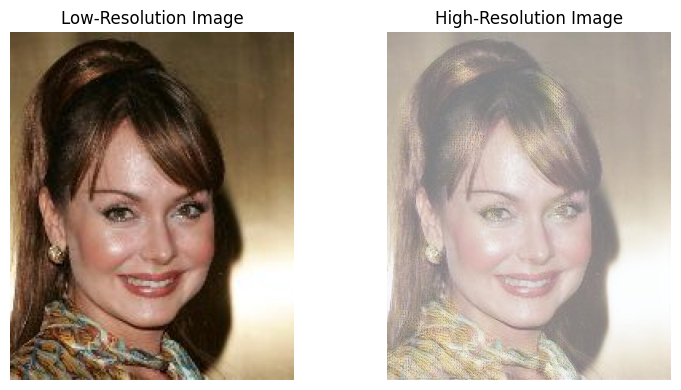

Comparing: 000010.jpg and 000010.jpg


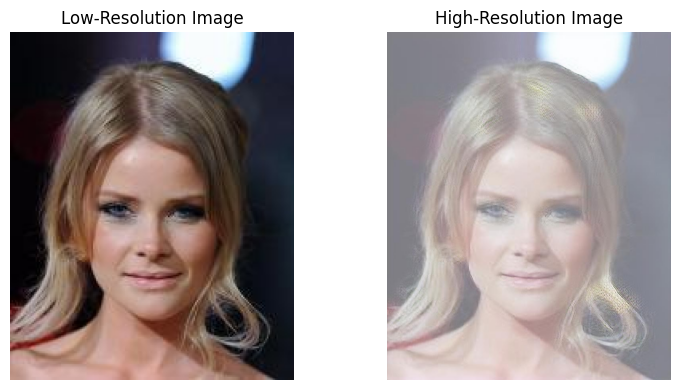

Comparing: 000012.jpg and 000012.jpg


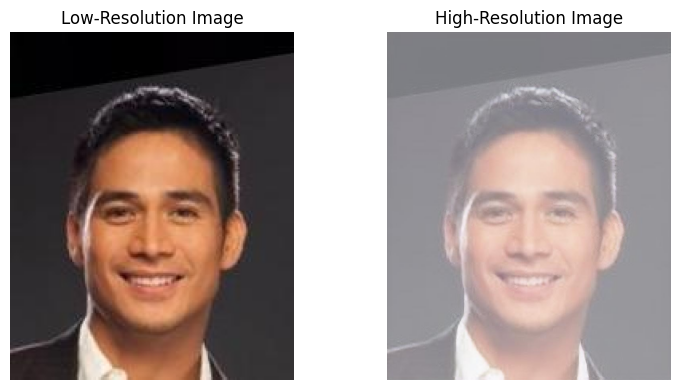

Comparing: 000013.jpg and 000013.jpg


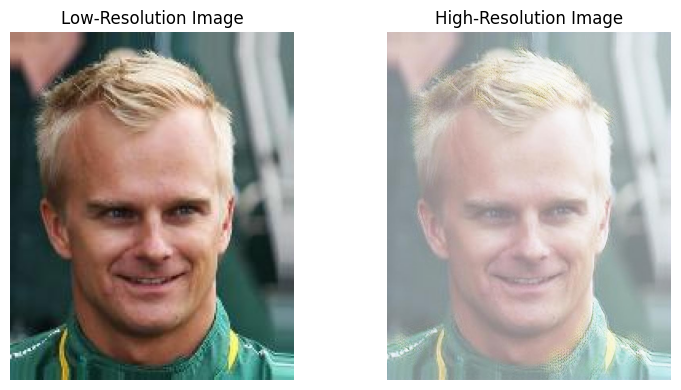

Comparing: 000019.jpg and 000019.jpg


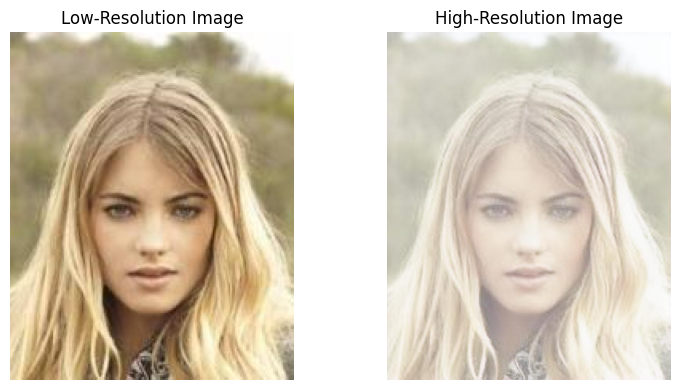

In [14]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from PIL import Image
import os
import numpy as np

# Define a function to compare low-res and high-res images
def compare_images(low_res_path, high_res_path):
    # Load the low-resolution image
    low_res = Image.open(low_res_path)
    if low_res.mode != "RGB":
        low_res = low_res.convert("RGB")

    # Load the high-resolution (super-resolved) image
    high_res = Image.open(high_res_path)

    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted the figsize
    axes[0].imshow(low_res)
    axes[0].set_title("Low-Resolution Image")
    axes[0].axis("off")

    axes[1].imshow(high_res)
    axes[1].set_title("High-Resolution Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Compare all images in a folder
def compare_folder(input_folder, output_folder, num_images=5):
    input_files = sorted(os.listdir(input_folder))
    output_files = sorted(os.listdir(output_folder))

    # Compare a subset of images
    for low_res_file, high_res_file in zip(input_files[:num_images], output_files[:num_images]):
        low_res_path = os.path.join(input_folder, low_res_file)
        high_res_path = os.path.join(output_folder, high_res_file)
        print(f"Comparing: {low_res_file} and {high_res_file}")
        compare_images(low_res_path, high_res_path)

# Paths to low-res and high-res folders
LOW_RES_FOLDER = "/content/drive/MyDrive/Data/hr/test/LR/"
HIGH_RES_FOLDER = "/content/drive/MyDrive/Data/hr/predict/"

# Compare images
compare_folder(LOW_RES_FOLDER, HIGH_RES_FOLDER, num_images=5)


**Conclusion**



Model Functionality:
   - The setup is designed to upscale the low-resolution image to match the high-resolution target. The generator will attempt to recreate details and sharpness, while the discriminator ensures realism by distinguishing between generated and real high-resolution images.

Metrics for Evaluation:
  - To evaluate the model's performance, I calculated metrics like:
      PSNR (Peak Signal-to-Noise Ratio): Measures the similarity between the generated image and the high-resolution target.
      SSIM (Structural Similarity Index): Evaluates perceptual similarity.
      Visual Quality: Check if the generator produces sharp, natural-looking results close to the high-resolution target.

Training Insights:
  - Ensure that the VGG loss effectively captures high-level perceptual features.
  Balance between pixel-wise loss and adversarial loss to avoid overly smooth or unrealistic outputs.
  Evaluate intermediate results at various epochs to monitor the model's ability to capture fine details.

Further Improvements:
  -Increase the number of residual blocks or adjust the learning rates to refine training.
  Experiment with more complex loss functions, like perceptual loss using higher VGG layers, for better results.
  Use data augmentation (already present in your code) to generalize the model better.